In [1]:
!pip install transformers torch scikit-learn accelerate -U
!pip install datasets 

   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.0 MB 5.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.8/12.0 MB 6.7 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/12.0 MB 6.7 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/12.0 MB 6.7 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/12.0 MB 6.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/12.0 MB 1.2 MB/s eta 0:00:09
   ------ --------------------------------- 1.8/12.0 MB 1.4 MB/s eta 0:00:08
   ------ --------------------------------- 1.8/12.0 MB 1.4 MB/s eta 0:00:08
   ------ --------------------------------- 1.8/12.0 MB 1.4 MB/s eta 0:00:08
   ------ --------------------------------- 1.8/12.0 MB 1.4 MB/s eta 0:00:08
   ------ --------------------------------- 2.1/12.0 MB 883.1 kB/s eta 0:00:12
   ------- -------------------------------- 2.4/12.0 MB 889.0 kB/s eta 0:00:11
  

In [2]:
import pandas as pd

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

MODEL_NAME = 'bert-base-uncased'
NUM_LABELS = 2

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary') 
    
    return {"accuracy": acc, "f1": f1}

In [6]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

In [ ]:
def prepare_data_for_bert(df, label_col='predicted_label'):

    df = df.copy()

    initial_len = len(df)
    df = df.dropna(subset=['label'])
    removed = initial_len - len(df)
    if removed > 0:
        print(f"Удалено {removed} (None/Errors).")


    df['label'] = df['label'].astype(int)
    return df

In [ ]:
def fine_tune_on_dataset(full_df: pd.DataFrame, dataset_name: str, epochs: int = 3):
    print(f"\nЗапуск дообучения: {dataset_name}")

    clean_df = prepare_data_for_bert(full_df, label_col='predicted_label')
    
    train_df, test_df = train_test_split(clean_df, test_size=0.2, random_state=42, stratify=clean_df['label'])
    
    print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

    train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
    test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    cols_to_remove = [c for c in tokenized_train.column_names if c not in ['input_ids', 'attention_mask', 'label']]
    tokenized_train = tokenized_train.remove_columns(cols_to_remove)
    tokenized_test = tokenized_test.remove_columns(cols_to_remove)
    
    tokenized_train.set_format("torch")
    tokenized_test.set_format("torch")

    output_path = f"../sentiment_analysis/results/{dataset_name}_ft"
    training_args = TrainingArguments(
        output_dir=output_path, 
        num_train_epochs=epochs,
        per_device_train_batch_size=8, 
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=50,
        eval_strategy="epoch", 
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        save_total_limit=1 
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    final_results = trainer.evaluate()
    print(f"Результаты {dataset_name}: {final_results}")
    
    save_path = f"./saved_models/{dataset_name}_bert"
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"saved in {save_path}")
    
    return final_results

In [3]:
human = pd.read_csv('../data/amdb_dataset/train/train_combined.csv')
gpt4o_mini = pd.read_csv('../sentiment_analysis/predictions_train_gpt-4o-mini.csv')
gemini_2_flash = pd.read_csv('../sentiment_analysis/predictions_train_gemini-2.0-flash.csv')
claude_3_5_haiku = pd.read_csv('../sentiment_analysis/predictions_train_claude-3-5-haiku.csv')


datasets_to_process = {
    "human": human,
    "gpt4o_mini": gpt4o_mini,
    "claude_3_5_haiku": claude_3_5_haiku,
    "gemini_2_flash": gemini_2_flash
}

display(human.head(2))
display(gpt4o_mini.head(2))
display(gemini_2_flash.head(2))
display(claude_3_5_haiku.head(2))

,text,mark,label
0,There are some bad movies out there. Most of t...,1,0
1,Amy Poehler and Rachel Dratch are among the fu...,4,0


,text,mark,label,pred_raw,pred_label,time_sec,prompt_tokens,completion_tokens,total_tokens
0,Despite the high ratings given to this film by...,2,0,Negative,0,0.702807,142,1,143
1,That's the question you have to ask yourself w...,2,0,Negative,0,0.622657,668,1,669


,text,mark,label,pred_raw,pred_label,time_sec,prompt_tokens,completion_tokens,total_tokens
0,Despite the high ratings given to this film by...,2,0,Negative,0,0.512161,133,2,135
1,That's the question you have to ask yourself w...,2,0,Negative,0,0.389369,670,2,672


,text,mark,label,pred_raw,pred_label,time_sec,prompt_tokens,completion_tokens,total_tokens
0,Despite the high ratings given to this film by...,2,0,Negative,0,1.183462,155,5,160
1,That's the question you have to ask yourself w...,2,0,Negative,0,0.795043,702,5,707


In [ ]:
all_results = {}

for name, df in datasets_to_process.items():
    try:
        results = fine_tune_on_dataset(df, name, epochs=3)
        all_results[name] = results
    except Exception as e:
        print(f"Ошибка при обработке датасета {name}: {e}")
        import traceback
        traceback.print_exc()

print("\nСводная таблица результатов")
print(pd.DataFrame(all_results).T)

## RESULTS

так как обучить на лок машине мне не удалось (недостаточно вычислительной мощности), и использовал https://colab.research.google.com

## human

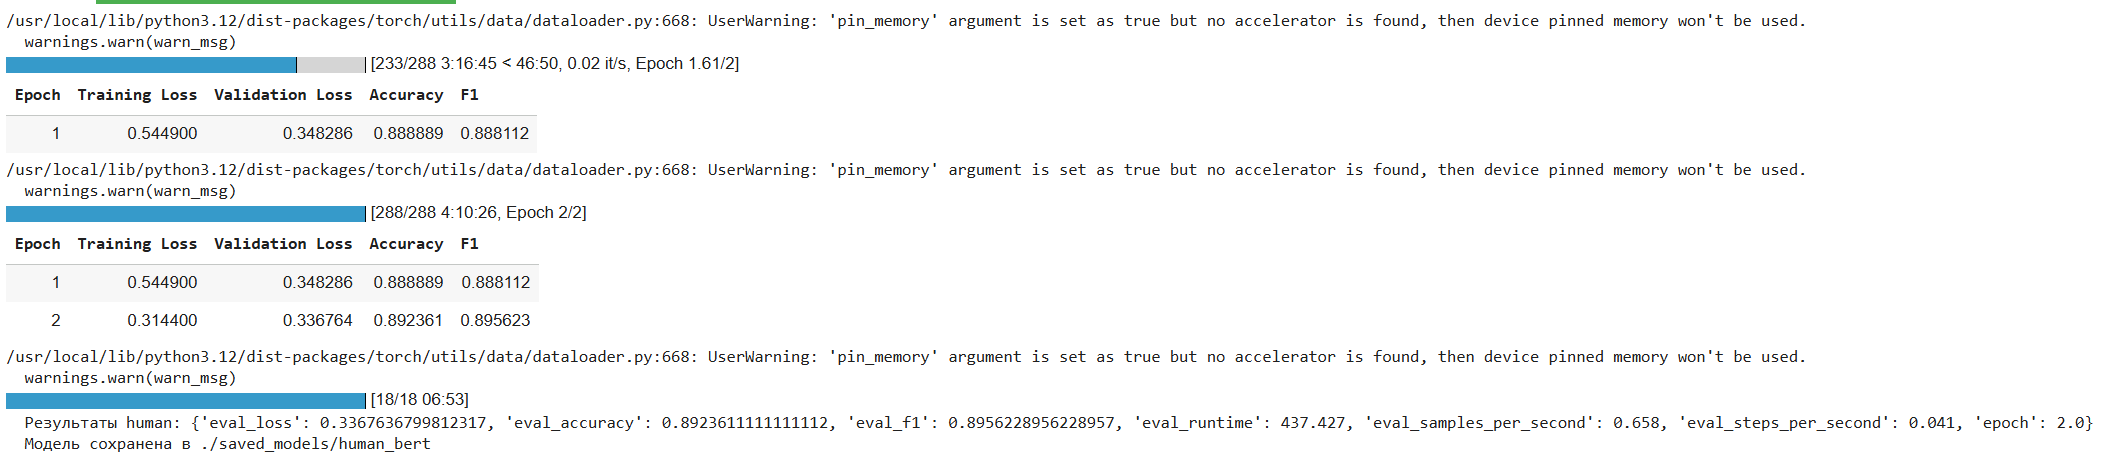

### результате на тестовой выборке
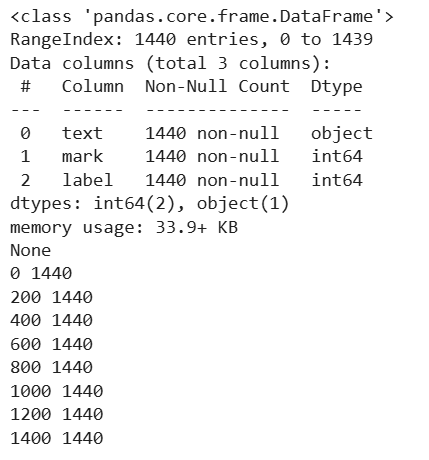

- Accuracy: 0.8583
- F1-score: 0.8582

## GPT 4o-mini

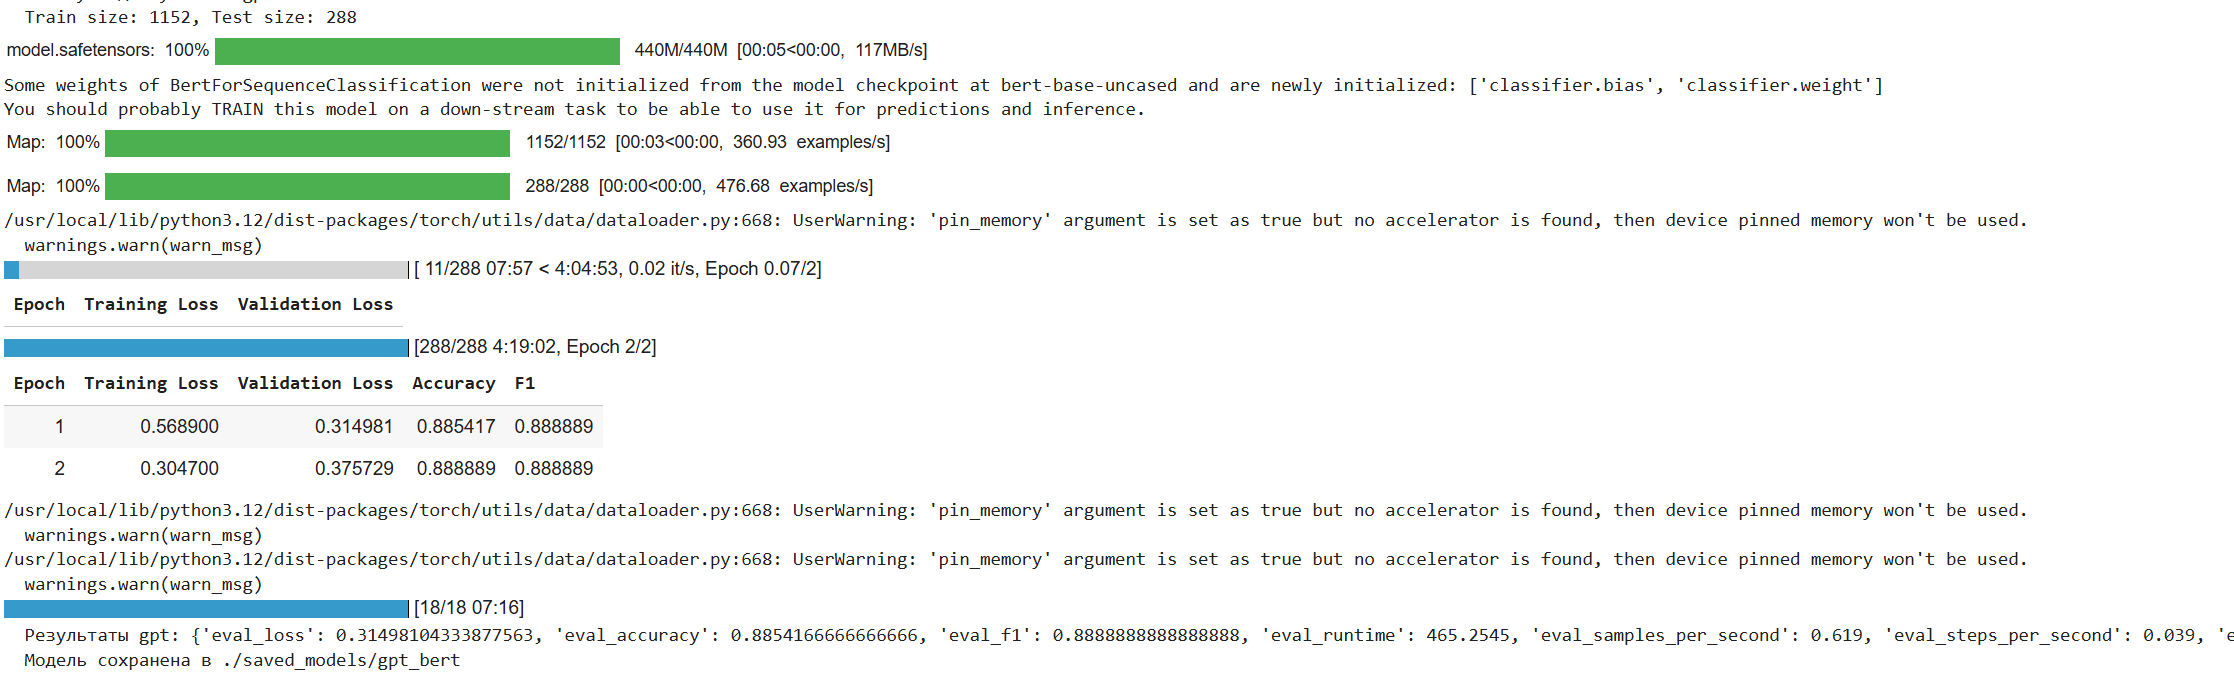

### результате на тестовой выборке

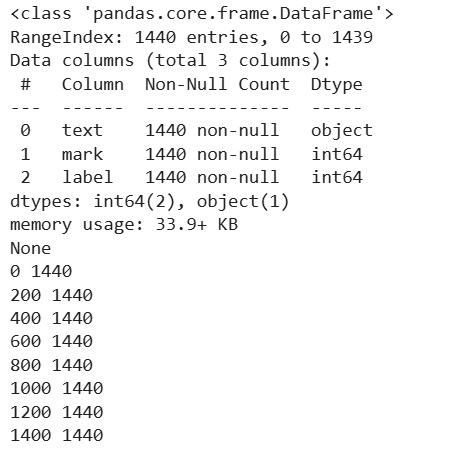
- Accuracy: 0.8472
- F1-score: 0.8468

## gemini-2.0-flash

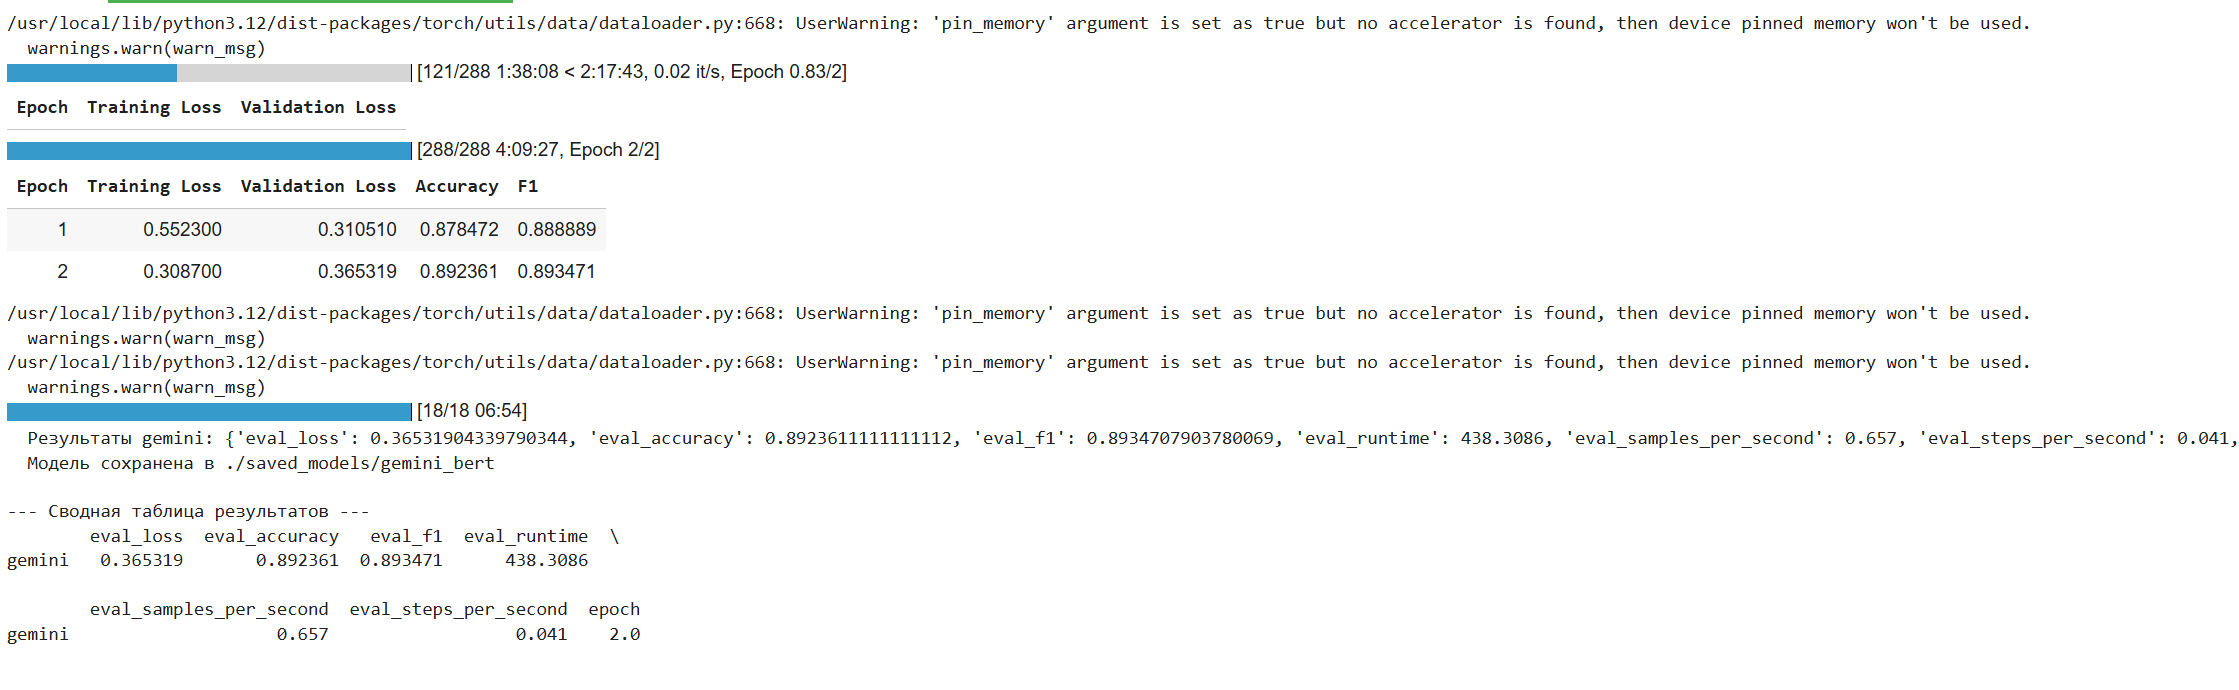

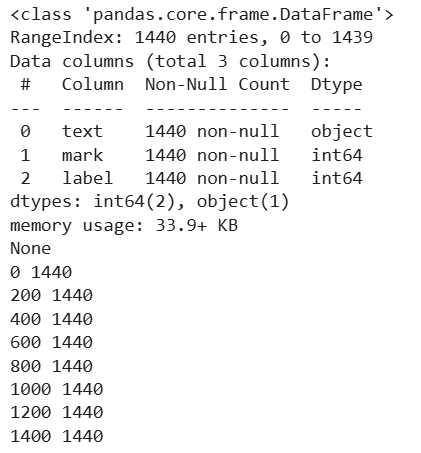
- Accuracy: 0.8750
- F1-score: 0.8750